In [16]:
import pandas as pd
import numpy as np
import re

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

from sklearn.decomposition import TruncatedSVD

import inflect
p = inflect.engine()

import nltk
import string
nltk.download('maxent_ne_chunker')
nltk.download('words')

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

from nltk.stem.wordnet import WordNetLemmatizer
lemma = WordNetLemmatizer()

from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(stop_words='english')

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

%matplotlib inline

[nltk_data] Error loading maxent_ne_chunker: <urlopen error [WinError
[nltk_data]     10060] A connection attempt failed because the
[nltk_data]     connected party did not properly respond after a
[nltk_data]     period of time, or established connection failed
[nltk_data]     because connected host has failed to respond>
[nltk_data] Error loading words: <urlopen error [WinError 10060] A
[nltk_data]     connection attempt failed because the connected party
[nltk_data]     did not properly respond after a period of time, or
[nltk_data]     established connection failed because connected host
[nltk_data]     has failed to respond>


Loading BokehJS ...

In [17]:
data=pd.read_csv("C:\\Users\\lingadhar_duggirala\\Desktop\\Keydocs\\today_data.csv")
data.drop_duplicates(subset=['text'],inplace=True)  #dropping duplicates

In [3]:
data.shape

(8957, 6)

In [31]:
data.head(3)

,Unnamed: 0,KeyFileCollection,SNPVersionID,KeyFileCollectionDetail,exhibit,text
0,0,118394904,722600258.0,326330013,EX-24.1,( document)------newmarket corporation-330 sou...
1,1,118400860,722711552.0,326350389,EX-24,(power of attorney)---------power of attorney-...
2,2,119512713,741305440.0,330165790,EX-24,(power of attorney (public): limited poa)-----...


In [18]:
def text_preprocess(txt):
    txt=str(txt)
    txt=re.sub('%',' percent',txt)
    txt=re.sub('\d+','',txt)
    txt=re.sub(r'[^a-zA-Z0-9]', ' ',txt)
    txt=re.sub("\s+"," ",txt)
    txt=re.sub('ex |exhibit|table of contents|execution( version| copy)|section|back to top|document','',str(txt).lower())
    txt=re.sub('^(\d+\s)+','',txt)
    txt=re.sub('^\s*\d+\.*\d*','',txt)
    stop_not = " ".join([i for i in txt.lower().split() if i not in stop_words])
    normalized = " ".join(lemma.lemmatize(word) for word in stop_not.split())
    return normalized

In [5]:
data['cleaned_text']=data.text.apply(lambda x:text_preprocess(x))

In [34]:
data.head(3)

,Unnamed: 0,KeyFileCollection,SNPVersionID,KeyFileCollectionDetail,exhibit,text,cleaned_text
0,0,118394904,722600258.0,326330013,EX-24.1,( document)------newmarket corporation-330 sou...,newmarket corporation south fourth street post...
1,1,118400860,722711552.0,326350389,EX-24,(power of attorney)---------power of attorney-...,power attorney power attorney undersigned repo...
2,2,119512713,741305440.0,330165790,EX-24,(power of attorney (public): limited poa)-----...,power attorney public limited poa limited powe...


In [13]:
def get_top_n_words(n_topics, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [15]:
words, word_values = get_top_n_words(n_top_words=20,keys=10,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=data['cleaned_text'])
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in Document Corpus (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

TypeError: get_top_n_words() got an unexpected keyword argument 'text_data'

In [14]:
small_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
small_text_sample = data['cleaned_text'].sample(n=5000, random_state=0).values

print('Text before vectorization: {}'.format(small_text_sample[123]))

small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)

print('Text after vectorization: \n{}'.format(small_document_term_matrix[123]))

Text before vectorization: john deere owner trust b statement noteholders class percent asset backed note due july class percent asset backed note due april class b floating rate asset backed note due april class percent asset backed note due october class percent asset backed note due july overcollateralization payment date jul one month libor libor determination date n class b interest rate n giving effect distribution payment date outstanding principal amount class note ii note pool factor b outstanding principal amount class note ii note pool factor c outstanding principal amount class b note ii b note pool factor outstanding principal amount class note ii note pool factor e outstanding principal amount class note ii note pool factor amount principal paid note class note per original principal amount b class note per original principal amount
Text after vectorization: 
  (0, 14251)	1
  (0, 13663)	1
  (0, 5116)	1
  (0, 8291)	1
  (0, 7586)	1
  (0, 15036)	5
  (0, 1684)	5
  (0, 7175)	5

In [129]:
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys
def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [133]:
n_topics = 9
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(small_document_term_matrix)

lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

top_n_words_lsa = get_top_n_words(20, lsa_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

Topic 1:  financial report registrant control statement company act reporting officer material internal period procedure disclosure exchange pursuant information based designed security
Topic 2:  company agreement share security shall stock term date corporation time warrant purchase director party common plan registration july board amended
Topic 3:  undersigned attorney fact power form act exchange security shall behalf company execute necessary required foregoing amendment authority file perform granted
Topic 4:  percent quarter million second net year share income result revenue sale compared june total value operating financial diluted company fund
Topic 5:  fund code price officer act group principal trust financial investment ethic security executive person rowe form report covered requirement exchange
Topic 6:  loan note date mortgage principal class trust bank agreement certificate balance asset payment percent period service servicer term distribution reconciliation
Topic 7: 

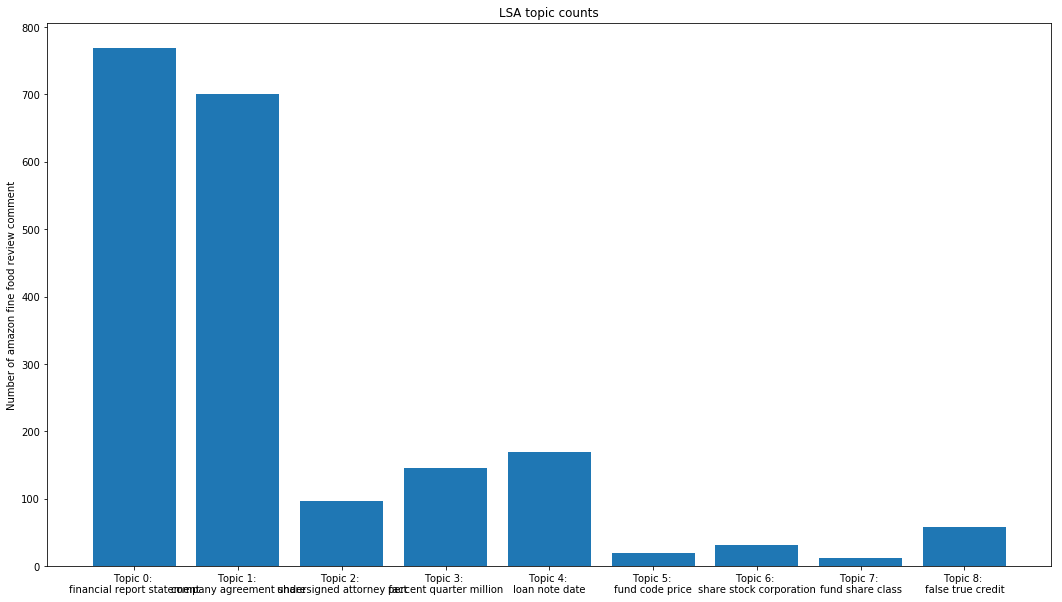

In [57]:
top_2_words = get_top_n_words(2, lsa_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]
fig, ax = plt.subplots(figsize=(18,10))
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
ax.set_xticklabels(labels);
ax.set_ylabel('Number of amazon fine food review comment');
ax.set_title('LSA topic counts');
plt.show()

In [131]:
lsa_topic_matrix

array([[ 4.48397243,  9.84681406, -6.12053301, ..., 13.38077451,
         1.62005493, -3.29125889],
       [ 7.64504551,  1.53410479,  1.34279206, ..., -4.15060771,
         0.96657254, -4.29797643],
       [ 1.6644037 ,  3.13161763, -1.24095221, ..., -0.26416407,
         2.35618508,  1.51905127],
       ...,
       [ 6.9209477 ,  5.77604656, -0.95170325, ..., -3.76044739,
         0.91264531, -1.5519138 ],
       [ 3.72910209,  0.68443354, -1.10809475, ..., -1.83281577,
        -0.44594719,  2.90520962],
       [13.45146354,  2.82998704, -2.97252727, ..., -5.79936702,
         0.9579655 ,  1.89804292]])

In [134]:
values = lsa_topic_matrix
index = [i for i in range(1, len(values)+1)]

Topic_df = pd.DataFrame(values, index=index,columns=[['Topic1','Topic2','Topic3','Topic4','Topic5','Topic6','Topic7','Topic8','Topic9']])

In [135]:
Topic_df.head(5)

,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9
1,4.483972,9.846807,-6.120637,1.753285,-3.544228,-1.356172,3.764648,13.379368,1.507269
2,7.645046,1.534108,1.342758,0.399731,4.848074,-3.565543,-0.321393,-4.160379,0.970511
3,1.664404,3.131619,-1.240870,0.069159,1.409391,4.218724,0.571940,-0.236760,2.364557
4,10.025659,-0.498664,-2.527084,0.312594,-2.413444,-0.495429,6.223403,-2.360665,-0.227889
5,12.341307,4.815940,3.674388,5.065102,27.751209,-14.564613,-10.698412,10.060299,2.705254


In [79]:
test_set=small_count_vectorizer.fit_transform(data.cleaned_text[2500:])

In [87]:
format(test_set[12])

'\n  (0, 12514)\t1\n  (0, 15458)\t8\n  (0, 3629)\t1\n  (0, 6030)\t3\n  (0, 4829)\t1\n  (0, 16761)\t1\n  (0, 3924)\t1\n  (0, 16837)\t1\n  (0, 1798)\t4\n  (0, 154)\t2\n  (0, 16183)\t1\n  (0, 6124)\t1\n  (0, 3883)\t1\n  (0, 4725)\t1\n  (0, 3882)\t1\n  (0, 18566)\t1\n  (0, 22559)\t1\n  (0, 14181)\t1\n  (0, 7857)\t1\n  (0, 9162)\t1\n  (0, 20179)\t1\n  (0, 496)\t1\n  (0, 3879)\t1\n  (0, 3880)\t1\n  (0, 18242)\t2\n  :\t:\n  (0, 19541)\t1\n  (0, 5123)\t1\n  (0, 16938)\t1\n  (0, 7755)\t1\n  (0, 5720)\t2\n  (0, 6034)\t9\n  (0, 18506)\t2\n  (0, 4173)\t2\n  (0, 1652)\t1\n  (0, 17348)\t1\n  (0, 15277)\t3\n  (0, 1836)\t1\n  (0, 20927)\t4\n  (0, 13711)\t4\n  (0, 7821)\t1\n  (0, 10634)\t4\n  (0, 4588)\t2\n  (0, 19367)\t1\n  (0, 14939)\t1\n  (0, 16173)\t4\n  (0, 20623)\t1\n  (0, 5289)\t5\n  (0, 5314)\t1\n  (0, 3561)\t2\n  (0, 15144)\t1'

### Latent Dirichlet Allocation

In [151]:
from sklearn.decomposition import LatentDirichletAllocation
lda_model = LatentDirichletAllocation(n_components=9, learning_method='online', 
                                          random_state=0, verbose=0)
lda_topic_matrix = lda_model.fit_transform(small_document_term_matrix)

In [152]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [153]:
top_n_words_lda = get_top_n_words(20, lda_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i+1), top_n_words_lda[i])

Topic 1:  financial control report registrant reporting statement internal procedure disclosure material period designed based act officer rule fact knowledge respect information
Topic 2:  company agreement share term shall stock plan date party fund time security purchase director common corporation percent set board right
Topic 3:  loan note date mortgage percent class principal trust bank certificate balance payment asset value security period distribution underlying servicer initial
Topic 4:  officer report act pursuant financial fund security company exchange code form certification oxley sarbanes principal executive chief date requirement respect
Topic 5:  percent quarter million statement company second financial year share net result income revenue forward july looking sale june ended operating
Topic 6:  false true share party xlon loan id company mai prospectus plc ordinary bank statement uw vista gas oil llc consent
Topic 7:  company security undersigned statement attorney sh

In [166]:
values=lda_topic_matrix
index = ["Document-"+str(i) for i in range(1, len(values)+1)]

LDA_TopicModel_df = pd.DataFrame(values, index=index,columns=[['Financial_Information','Agreements','Certificates','Certifications','Financial_Statements','Consent','Junk1','Junk2','Junk3']])

In [167]:
LDA_TopicModel_df.head(6)

,Financial_Information,Agreements,Certificates,Certifications,Financial_Statements,Consent,Junk1,Junk2,Junk3
Document-1,0.000490,0.785420,0.138012,0.000490,0.073630,0.000490,0.000490,0.000490,0.000490
Document-2,0.001308,0.001307,0.001307,0.938930,0.051916,0.001307,0.001308,0.001308,0.001308
Document-3,0.000817,0.286437,0.363602,0.178215,0.044128,0.035701,0.089464,0.000817,0.000818
Document-4,0.310977,0.000512,0.000512,0.000512,0.611565,0.020079,0.054819,0.000512,0.000512
Document-5,0.000463,0.000463,0.000463,0.996296,0.000463,0.000463,0.000463,0.000463,0.000463
Document-6,0.028138,0.001222,0.001222,0.211663,0.001222,0.614121,0.139969,0.001221,0.001222


In [171]:
data.cleaned_text[5]

'poa limited power attorney know men present jeffrey c blair undersigned high street city denver county denver state colorado hereby make constitute appoint melissa trippel anne rand catherine white anderson inc briarfield boulevard maumee ohio true lawful limited attorney fact name place stead giving severally unto said melissa trippel anne rand catherine white full power individually execute file security exchange commission sec limited attorney fact sec form required filed security act security exchange act amended ii execute deliver exercise order certificate commitment agreement necessary appropriate connection exercise stock option share anderson inc act effectuate foregoing execute submit sec filing necessary appropriate connection therewith connection beneficial ownership equity security anderson inc option equity security undersigned hereby grant attorney fact full power authority perform every act thing whatsoever requisite necessary proper done exercise right power herein gr

In [154]:
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.003s...
[t-SNE] Computed neighbors for 5000 samples in 0.523s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.000099
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.549572
[t-SNE] KL divergence after 2000 iterations: 0.573662


In [144]:
# Define helper functions
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics]

In [155]:
top_3_words_lda = get_top_n_words(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
lda_mean_topic_vectors = get_mean_topic_vectors(lda_keys, tsne_lda_vectors)

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lda_vectors[:,0], y=tsne_lda_vectors[:,1], color=colormap[lda_keys])

for t in range(n_topics):
    label = Label(x=lda_mean_topic_vectors[t][0], y=lda_mean_topic_vectors[t][1], 
                  text=top_3_words_lda[t], text_color=colormap[t])
    plot.add_layout(label)

show(plot)

In [148]:
tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_matrix)


top_3_words_lsa = get_top_n_words(3, lsa_keys, small_document_term_matrix, small_count_vectorizer)
lsa_mean_topic_vectors = get_mean_topic_vectors(lsa_keys, tsne_lsa_vectors)

plot = figure(title="t-SNE Clustering of {} LSA Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lsa_vectors[:,0], y=tsne_lsa_vectors[:,1], color=colormap[lsa_keys])

for t in range(n_topics):
    label = Label(x=lsa_mean_topic_vectors[t][0], y=lsa_mean_topic_vectors[t][1], 
                  text=top_3_words_lsa[t], text_color=colormap[t])
    plot.add_layout(label)
    
show(plot)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.006s...
[t-SNE] Computed neighbors for 5000 samples in 0.487s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.148995
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.444855
[t-SNE] KL divergence after 2000 iterations: 0.738884


### LDA has clear separations between the Topics than LSA

In [174]:
import gensim.models

C:\Users\lingadhar_duggirala\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [182]:
corpus=[]
for ind,row in data.iterrows():
    corpus.append(row['cleaned_text'].split())

In [186]:
bigram = gensim.models.Phrases(corpus, min_count=5, threshold=100) 
#trigram = gensim.models.Phrases(bigram[document_cleaned], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
data_words_bigrams = make_bigrams(corpus)
# Creating the term dictionary of our courpus, 
# where every unique term is assigned an index. 
dictionary = gensim.corpora.Dictionary(data_words_bigrams)

In [187]:
# Converting list of documents (corpus) 
# into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(text) for text in data_words_bigrams]
# Build the LDA model
from gensim.models import LdaModel
lda_model = LdaModel(corpus=doc_term_matrix,id2word=dictionary,num_topics=10,random_state=100,
                     update_every=1,chunksize=2000,passes=1,alpha='auto',per_word_topics=True)
lda_model.print_topics() # it will print topic model

[(0,
  '0.020*"loan" + 0.012*"mortgage" + 0.011*"value" + 0.010*"date" + 0.008*"item" + 0.007*"service" + 0.007*"payment" + 0.007*"term" + 0.006*"respect" + 0.006*"portion"'),
 (1,
  '0.044*"financial" + 0.043*"report" + 0.034*"registrant" + 0.031*"control" + 0.023*"statement" + 0.023*"officer" + 0.022*"act" + 0.019*"reporting" + 0.019*"material" + 0.016*"internal"'),
 (2,
  '0.031*"note" + 0.022*"date" + 0.018*"detail" + 0.018*"class" + 0.017*"loan" + 0.017*"trust" + 0.015*"percent" + 0.015*"principal" + 0.013*"interest" + 0.011*"period"'),
 (3,
  '0.034*"company" + 0.025*"share" + 0.019*"agreement" + 0.015*"stock" + 0.013*"corporation" + 0.011*"shall" + 0.010*"security" + 0.009*"common" + 0.009*"warrant" + 0.008*"registration"'),
 (4,
  '0.061*"undersigned" + 0.052*"attorney" + 0.034*"fact" + 0.033*"power" + 0.025*"form" + 0.022*"act" + 0.022*"security" + 0.021*"exchange" + 0.016*"shall" + 0.015*"company"'),
 (5,
  '0.041*"fund" + 0.032*"statement" + 0.017*"consent" + 0.016*"financia

In [191]:
from gensim.models.coherencemodel import CoherenceModel
# Compute Perplexity, a measure of how good the model is. lower the better.
print('\nPerplexity: ', lda_model.log_perplexity(doc_term_matrix))
# Compute Coherence Score for lda model
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=dictionary, coherence='c_v')
coherence_lda_c_v = coherence_model_lda.get_coherence()
print('\nCoherence Score using c_v: ', coherence_lda)
# Compute Coherence Score for lda model
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=dictionary, coherence='u_mass')
coherence_lda_u_mass = coherence_model_lda.get_coherence()
print('\nCoherence Score using u_mass: ', coherence_lda_u_mass)


Perplexity:  -6.839358163259592


BrokenPipeError: [Errno 32] Broken pipe